
# Reconocedor Facial con Redes Neuronales
## Implementación: utilizando OpenCV y Redes Neuronales Convolucionales

Pasos Necesarios:

[**Paso 1**](#step0) : Detectar las caras a partir de modelos definidos en OpenCV.

[**Paso 2**](#step1) : Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras.

[**Paso 3**](#step1) : Aplicar el conocimiento de la CNN a cada una de las caras detectadas en las imágenes en el [**Paso 1**](#step0).

In [1]:
# Importacion de las libreias requeridas para esta seccion 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # Libreria OpenCV 
#from PIL import Image
import time
from keras.models import load_model

# Funciones Auxiliares 
def read_image(path):
    """ Method to read an image from file to matrix """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_image(image, title=''): 
    """ It plots an image as it is in a single column plot """
    # Dibujamos nuestra imagen usando subplots para espeificar un tamaño y titulo
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title(title)
    ax1.imshow(image)

Using TensorFlow backend.


<a id='step0'></a>
# Paso 1: Detectar las caras a partir de modelos definidos en OpenCV

Definición de los métodos que utilizaremos.

get_faces: A partir de una imagen se devuelve el conjunto de caras detectadas

plot_faces: Muestra las caras detectadas sobre la imagen original




In [2]:
def get_faces(image):
    """
    Esto devuelve una matriz con las caras detectadaen una imagen, cada cara se define como lo hace OpenCV:
        x superior izquierda
        y superior izquierda 
        anchura 
        altura.
    """
    # Para evitar sobre escribir la imagen
    image_copy = np.copy(image)
    
    # El filtro funciona con imagenes de escalas de grises 
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # Se extrae el detector de cara pre-entrenado de un archivo xml
    face_classifier = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
    
    # Detectamos las caras en la imagen 
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    return faces 

def draw_faces(image, faces=None, plot=True):
    """
    Trazamos una imagen con las caras detectadas. Si rostros es Ninguno, también busca los rostros.
    """
    if faces is None:
        faces = get_faces(image)
    
    # Para evitar sobre escribir 
    image_with_faces = np.copy(image)
    
    # Obtenemos el cuadro delimitador para cada cara detectada
    for (x,y,w,h) in faces:
        # Se agrega un cuadro de límite rojo a la imagen de detecciones
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (255,0,0), 3)
        
    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces

def plot_image_with_keypoints(image, image_info):
    """
    Traza los puntos clave dados en formato (x, y)
    """
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (face, keypoints) in image_info:
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)

Rostros Detectados: 4


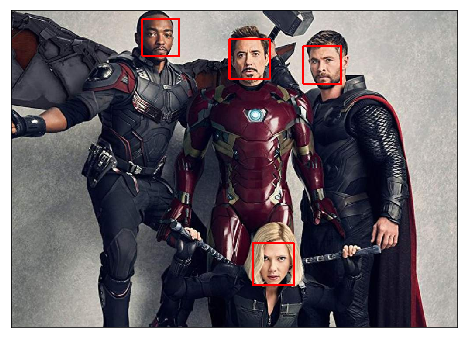

In [3]:
image = read_image('images/Avengers.jpg')
faces = get_faces(image)
print("Rostros Detectados: {}".format(len(faces)))
draw_faces(image, faces)

<a id='step1'></a>
# Paso 2:  Definición y entrenamiento de una Red Neuronal Convolucional (CNN) en Keras

En este paso se define una red neuronal convolucional para sacar los keypoints de cada una de las fotos detectadas. La implementación se realizará en Keras, usando Tensorflow como backend.

Para poder hacer uso del conocimiento de la red neuronal hay que entrenarla con datos previos. En kaggle podemos encontrar [este dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) que contiene 60MB  de imágenes, cada una con un tag en los keypoints.

Estos keypoints serán 15: 
    4 en la boca
    1 en la nariz
    3 en cada ojo
    2 en cada ceja.

Lo primero que haremos será cargar estas imágenes y prepararlas para el entrenamiento


In [4]:
from utils import *

# Load training set
# load_data es un método definido en el fichero utils para cargar las imágenes.
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


## Visualización de los datos de entrenamiento

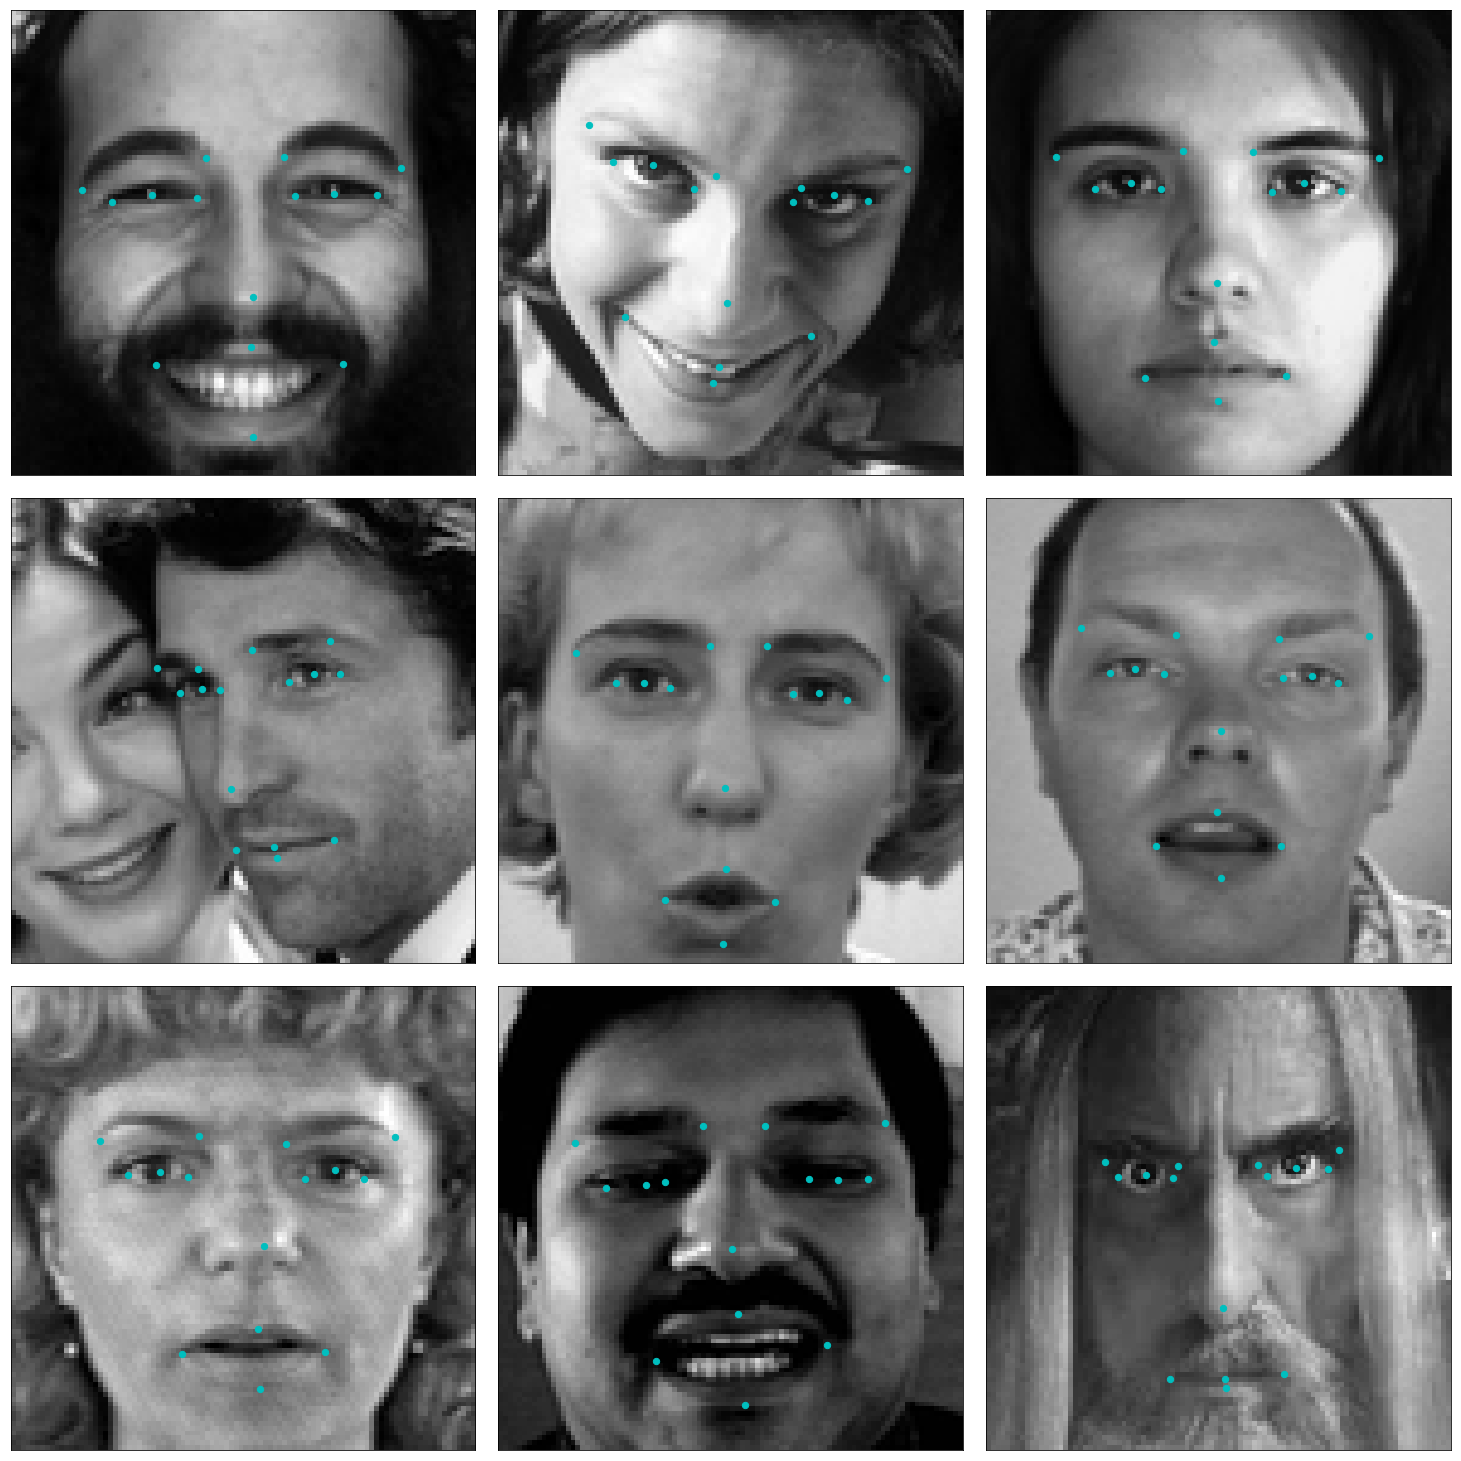

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

## Definición de la Red Neuronal Convolucional

La red neuronal definida tiene una complejidad básica-media. Puede ser interesante ver cómo se alternan capas convolucionales que dan profundidad a la red con capas de "pooling", que reducen el tamaño de las imágenes.

También se puede ver cómo se han añadido capas de Dropout (descarte de un porcentaje de los resultados intermedios) para evitar el overfitting.

Al final se termina con una capa densa de 30 valores, un valor por cada posición "x" e "y" de los 15 keypoints

In [6]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense


# Your model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)
shape = (96,96)
model = Sequential()
model.add(Convolution2D(16,(2,2),padding='same',input_shape=(96,96, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Convolution2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))


# Summarize the model
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

## Compilación y entrenamiento de la Red Neuronal Convolucional

Para compilar y entrenar una red neuronal dependen de la configuración de lo que se denominan "hiperparámetros".

Se han realizado diferentes pruebas y los mejores resultados obtenidos han sido los siguientes:

optimizer: adam

loss: mse

batch_size: 20

validation:split: 0.2

In [7]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, History  

epochs = 50
histo = History()

## Compilacion del modelo
def compile_model(model, epochs):
    
    filepath = 'model.hdf5'
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=filepath, 
                                   verbose=1, save_best_only=True)

    ## Entrenamiento del modelo 
    hist = model.fit(X_train, y_train, validation_split=0.2,
              epochs=epochs, batch_size=20, callbacks=[checkpointer, histo], verbose=1)
    
    model.save(filepath)
    
    return hist

def show_training_validation_loss(hist, epochs):
    plt.plot(range(epochs), hist.history[
             'val_loss'], 'g-', label='Val Loss')
    plt.plot(range(epochs), hist.history[
             'loss'], 'g--', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

# TODO: Entrenamiento de la red.
train_net = False

if train_net is True:
    hist = compile_model(model, epochs) 
else:
    model.load_weights('model.hdf5')
    
    print
    

In [8]:
# Se visualiza el entrenamiento y validacion perdida de la red neuronal 

if train_net is True:
    show_training_validation_loss(hist, epochs)

<a id='step2'></a>
# Paso 3:  Aplicar el conocimiento de la CNN a cada una de las caras detectadas

Vamos a elegir la misma imagen que al al principio, y vamos a representar en las caras los keypoints de cada uno.

La red neuronal se ha entrenado con imágenes de 96x96, por lo que habrá que escalar el rectángulo que delimita las caras a esa escala para poder extraer los keypoints

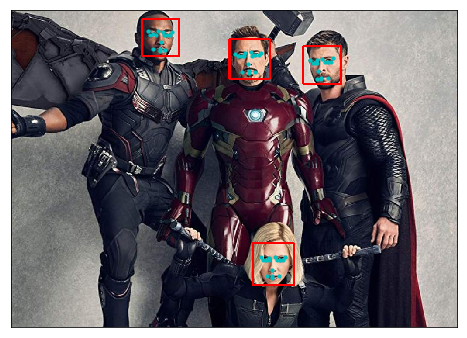

In [9]:
def get_keypoints(image, faces=None):
    
    # lista de parejas (rostros, keypoints)
    result = []
    
    if faces is None:
        faces = get_faces(image)
    
    # Se elige el mismo tamaño que el conjunto de entrenamiento / validacion
    faces_shape = (96, 96)
    
    # Para evitar el sobre escribimiento
    image_copy = np.copy(image)
    
    # Para cada rostro se detectaron los keypoints y se muestran los features
    for (x,y,w,h) in faces:

        # Se recorta la region del rostro 
        face = image_copy[y:y+h,x:x+w]

        # Convertimos la imagen a escala de grises y se redimensiona (CNN recive imagenes de 96x96x1)
        gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        resize_gray_face = cv2.resize(gray_face, faces_shape) / 255

        # Formateamos las entradas con el formato de (1, 96, 96, 1)
        inputs = np.expand_dims(np.expand_dims(resize_gray_face, axis=-1), axis=0)
                                
        # obtenemos el resultados de los keypoints
        predicted_keypoints = model.predict(inputs)

        # Se presentan todos los keypoints en una sola matriz plana, y se recuperan los valores keypoints en (x,y) con datos (idx, idx+1)
        predicted_keypoints = np.squeeze(predicted_keypoints)
        
        keypoints = []        
        for idx in range(0, len(predicted_keypoints), 2):
            # Factor de Escala (se revierte la escala)
            x_scale_factor = face.shape[0]/faces_shape[0] 
            y_scale_factor = face.shape[1]/faces_shape[1] 

            # Offset del centro de la dispersion 
            x_center_left_offset = predicted_keypoints[idx] * faces_shape[0]/2 + faces_shape[0]/2 
            y_center_left_offset = predicted_keypoints[idx + 1] * faces_shape[1]/2 + faces_shape[1]/2
            
            x_center = int(x + (x_scale_factor * x_center_left_offset))
            y_center = int(y + (y_scale_factor * y_center_left_offset))

            keypoints.append([x_center, y_center])
        
        result.append([(x,y,w,h), keypoints])
    
    return result

def show_image_and_features(image_path):
    image = read_image(image_path)
    faces = get_faces(image)
    keypoints = get_keypoints(image, faces)
    image_with_faces = draw_faces(image, faces ,plot=False)
    plot_image_with_keypoints(image_with_faces, keypoints)

show_image_and_features('images/Avengers.jpg')


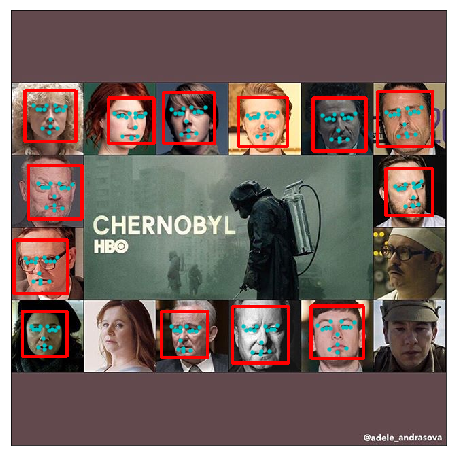

In [18]:
show_image_and_features('images/chernobyl.jpg')


## Aplicacion: Colocacion de "gafas" a partir de los keypoints

Primero tenemos que saber qué índice contiene qué keypoint. 
En la documentacion del dataset de kaggle podemos encontrar:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Cuando hacemos referencia a izquierda o derecha es con respecto a la persona. En la imagen anterior, el ojo izquierdo es el que tiene un valor de x mayor.

Después lo adaptamos a nuestra imagen: 

<img src="images/thug_life.png" width=400 height=300/>

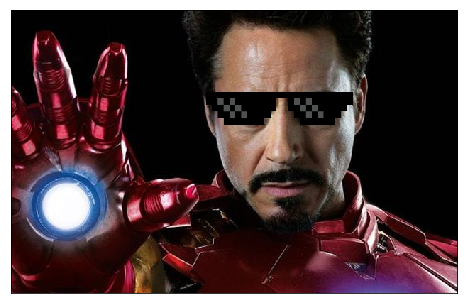

In [10]:
# Primero determinamos el rectangulo delimitador para los ojos, debajo de los keypoints de las gafas de sol
# Se utiliza el rectangulo delimitador en la figura, como un mapa para el filtro en los keypoints de los ojos
# en base a experimentacion se deteminan los puntos necesarios para que queden "bien centrados"

# glasses_triangle_vertices = np.array([(280,220), (2800,220), (280,600)]).astype(np.float32)
thug_glasses_triangle_vertices = np.array([(65,10), (490,10), (65,70)]).astype(np.float32)

def thug_image(image):
    faces = get_faces(image)
    image_info = get_keypoints(image, faces)
    
    # CArgamos laimagen de los lentes 
    # cv2.IMREAD_UNCHANGED,es la opcion utilizada para las gafas
    
    sunglasses = cv2.imread("images/thug_life.png", cv2.IMREAD_UNCHANGED)    
    alpha_channel = sunglasses[:,:,3]
    
    for (face, keypoints) in image_info:
    
        # solo utilizamos los keypoints relacionados con los ojos (desde 0 a 9)
        eye_keypoints = keypoints[:10]

        # Se calcula el rectangulo delimitador de los ojos 
        eye_boundingRect = cv2.boundingRect(np.array(eye_keypoints).astype(np.float32))
        # Construimos el triagulo de vertices requeridos por cv2.getAffineTransform()
        eyes_triangle_vertices = np.array([(eye_boundingRect[0],eye_boundingRect[1]), 
                                           (eye_boundingRect[0]+eye_boundingRect[2],eye_boundingRect[1]), 
                                           (eye_boundingRect[0],eye_boundingRect[1]+eye_boundingRect[3])]).astype(np.float32)
        # Se calcula el afinamiento en la matriz transformada para los 2 conjuntos de 3 puntos (gafas y ojos)
        map_matrix = cv2.getAffineTransform(thug_glasses_triangle_vertices, eyes_triangle_vertices)
        # Aplicamos el afinamiento a la transformacion de las gafas 
        transformed_sunglasses = cv2.warpAffine(sunglasses, map_matrix, (image.shape[1], image.shape[0]))
        # Construimos una mascara binaria de los pixeles donde estaran las gafas 
        transformed_sunglasses_mask = transformed_sunglasses[:,:,3] > 0
        # Sobre escribimos los pixeles en la imagen original con los pixeles de las gafas usando la mascara antes obtenida
        image[:,:,:][transformed_sunglasses_mask] = transformed_sunglasses[:,:,0:3][transformed_sunglasses_mask]
    
    return image   

thug_life_image = thug_image(read_image('images/Ironman.jpg'))
plot_image(thug_life_image)
    

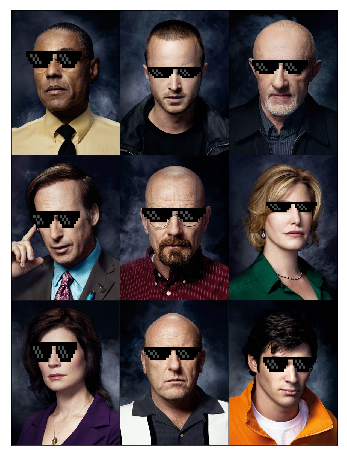

In [21]:
thug_life_image = thug_image(read_image('images/breaking_bad.jpg'))
plot_image(thug_life_image)

## Pruebas Online: Aplicacion de un "filtro" con la web cam del computador 

In [22]:
import cv2
import time 
from keras.models import load_model
def laptop_camera_go():
    # Creamos la instancia de captura de video 
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Tratamos de obtener el primer cuadro
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # mantenemos elflujo de video abierton
    while rval:
        # se dibuja la imagen desde la camara con los detectores marcados
        frame = thug_image(frame)
        cv2.imshow("face detection activated", frame)
        
        # funcionalida de salida - presionar cualquier tecla para salir del video de la laptop 
        key = cv2.waitKey(20)
        if key > 0: # salida cuando se presione cualquier tecla
            # cerramos la ventana 
            cv2.destroyAllWindows()
            
            # hack from stack overflow for making sure window closes on osx --> https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # leemos el siguiente recuadro
        time.sleep(0.05)             # control de velocidad de cuadros para el cálculo (por defecto 20 cuadros por segundo)
        rval, frame = vc.read()  

In [23]:
# Corremos el programa con la camara de la laptop
laptop_camera_go( )